In [310]:
import numpy as np
import os
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz
from sklearn.inspection import permutation_importance
import pydot
import matplotlib.pyplot as plt
import datetime
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error, accuracy_score, r2_score
import geopandas as gpd
import warnings
import shap
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import random
import math
import time
import sklearn

In [311]:
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
       # print(n_samples)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int((self.n_splits-1)/self.n_splits * (stop - start)) + start
            yield indices[start: mid], indices[mid: stop]

In [312]:
def subsets (l):
    subset_list = []
    for i in range(len(l) + 1):
        for j in range(i):
            subset_list.append(l[j: i])
    return subset_list

In [313]:
os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\sandbox\\notebooks\\crop_fires\\Model\\Data')
data_harvest = pd.read_csv('Data_final.csv', index_col = 0)
data_all = pd.read_csv('Data_all_final.csv', index_col = 0)
#data = gpd.read_file('Data_full_mandals.geojson')

os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\src\\data_preprocessing\\tsdm\\')
mandal_boundaries = gpd.read_file('Mandal_Boundary.shp')
mandal_boundaries = mandal_boundaries.reset_index()

In [314]:
warnings.filterwarnings('ignore')

In [315]:
del data_harvest['geometry']
data_harvest = pd.merge(data_harvest, mandal_boundaries[['index', 'geometry']], how='left', on=['index'])

del data_all['geometry']
data_all = pd.merge(data_all, mandal_boundaries[['index', 'geometry']], how='left', on=['index'])


Data Split

In [316]:
data_all.columns

Index(['index', 'Mandal_Nam', 'Dist_Name', 'ModifiedDateTime', 'Year', 'Month',
       'Fires', 'FRP', 'Season', 'NO2', 'PM2.5', 'SSM_mean', 'SSM_median',
       'SSM_min', 'SSM_max', 'SSM_percentile_90', 'PRE_mean', 'PRE_median',
       'PRE_min', 'PRE_max', 'PRE_percentile_90', 'PRE_sum', 'POP_mean',
       'POP_median', 'ST_mean', 'ST_median', 'ST_min', 'ST_max',
       'ST_percentile_90', 'RWI_mean', 'RWI_median', 'RWI_min', 'RWI_max',
       'RWI_percentile_90', 'BA_mean', 'BA_median', 'BA_sum', 'Area_Crops',
       'Crops_Prop', 'Area_Trees', 'Trees_Prop', 'Area_Built_Area',
       'Built_Area_Prop', 'PowP_score', 'Soil Type', 'Area',
       'Harvested_CropA_Paddy', 'Harvested_CropA_Maize',
       'Harvested_CropA_Soybean', 'Harvested_CropA_Cotton',
       'Harvested_CropA_Chillies', 'Harvested_CropA_Turmeric',
       'SoilT_Chromic_Luvisols', 'SoilT_Chromic_Vertisols',
       'SoilT_Eutric_Nitosols', 'SoilT_Lithosols', 'SoilT_Pellic_luvisols',
       'SoilT_Plinthic_Luvisols', '

Predictors

In [317]:
predictors = ['NO2', 'PM2.5']

Features

In [318]:
feature_list =  ['SSM_mean', 'SSM_median', 'SSM_min',
       'SSM_max', 'SSM_percentile_90', 'PRE_mean', 'PRE_median', 'PRE_min',
       'PRE_max', 'PRE_percentile_90', 'PRE_sum', 'POP_mean', 'POP_median',
       'ST_mean', 'ST_median', 'ST_min', 'ST_max', 'ST_percentile_90',
       'RWI_mean', 'RWI_median', 'RWI_min', 'RWI_max', 'RWI_percentile_90',
       'BA_mean', 'BA_sum', 'Area_Crops', 'Crops_Prop',
       'Area_Trees', 'Trees_Prop', 'Area_Built_Area', 'Built_Area_Prop',
       'PowP_score', 'Soil Type', 'Area',
       'Harvested_CropA_Paddy', 'Harvested_CropA_Maize',
       'Harvested_CropA_Soybean', 'Harvested_CropA_Cotton',
       'Harvested_CropA_Chillies', 'Harvested_CropA_Turmeric', 'SoilT_Chromic_Luvisols',
       'SoilT_Chromic_Vertisols', 'SoilT_Eutric_Nitosols', 'SoilT_Lithosols',
       'SoilT_Pellic_luvisols', 'SoilT_Plinthic_Luvisols',
       'SoilT_Vertic_Cambisols']


In [319]:
feature_list_comb = [
                     ['SoilT_Chromic_Luvisols','SoilT_Chromic_Vertisols', 'SoilT_Eutric_Nitosols', 'SoilT_Lithosols','SoilT_Pellic_luvisols', 'SoilT_Plinthic_Luvisols', 'SoilT_Vertic_Cambisols'],
                     ['Built_Area_Prop', 'Area_Built_Area', 'POP_mean', 'POP_median', 'RWI_mean', 'RWI_median', 'RWI_min', 'RWI_max', 'RWI_percentile_90'],
                     ['POP_mean', 'POP_median'],
                     ['RWI_mean', 'RWI_median', 'RWI_min', 'RWI_max', 'RWI_percentile_90'],
                     ['Built_Area_Prop', 'Area_Built_Area'],
                     ['SSM_mean', 'SSM_median', 'SSM_min','SSM_max', 'SSM_percentile_90', 'ST_mean', 'ST_median', 'ST_min', 'ST_max', 'ST_percentile_90'],
                     ['PRE_mean', 'PRE_median', 'PRE_min','PRE_max', 'PRE_percentile_90', 'PRE_sum'],
                     ['SSM_mean', 'SSM_median', 'SSM_min','SSM_max', 'SSM_percentile_90'],
                     ['ST_mean', 'ST_median', 'ST_min', 'ST_max', 'ST_percentile_90'],
                     ['BA_sum'],
                     ['Area_Crops', 'Area_Trees', 'Area_Built_Area', 'Crops_Prop', 'Trees_Prop', 'Built_Area_Prop', 'Area'],
                     ['Harvested_CropA_Paddy', 'Harvested_CropA_Maize','Harvested_CropA_Soybean', 'Harvested_CropA_Cotton', 'Harvested_CropA_Chillies', 'Harvested_CropA_Turmeric'],
                     ['PowP_score']]

# Parameter Tuning

In [320]:
def RandomSearch(n_estimators, max_features, max_depth, min_samples_split, min_samples_leaf, bootstrap, k_fold, btscv, train_data, predictor, feature_list, n_iters):

    X = train_data[feature_list]
    Y = train_data[predictor]

    rf = RandomForestRegressor()

    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'bootstrap': bootstrap}


    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = n_iters, cv = btscv, verbose=0, n_jobs = -1)
    # Fit the random search model
    rf_random.fit(X,Y)


    return(rf_random.best_params_)


In [321]:
def GridSearch(parameters_tuned, max_depth_adds, min_samples_leaf_adds, min_samples_split_adds, n_estimators_adds, btscv, train_data, predictor, feature_list):

    features = [i for i in feature_list]    
    X = train_data[features]
    Y = train_data[predictor]

    min_max_depth = parameters_tuned['max_depth'] - max_depth_adds
    min_n_esimators = parameters_tuned['n_estimators'] -  n_estimators_adds
    min_min_samples_split = parameters_tuned['min_samples_split'] - min_samples_split_adds
    min_min_samples_leaf = parameters_tuned['min_samples_leaf'] - min_samples_leaf_adds

    if min_max_depth <=0:
        min_max_depth = 1
    if min_n_esimators <=0:
        min_n_esimators = 100
    if min_min_samples_split <=1:
        min_min_samples_split = 2
    if min_min_samples_leaf <=0:
        min_min_samples_leaf = 1


    param_grid = {
    'bootstrap': [parameters_tuned['bootstrap']],
    'max_depth': [min_max_depth, parameters_tuned['max_depth'], parameters_tuned['max_depth']+ max_depth_adds ],
    'max_features': [parameters_tuned['max_features']],
    'min_samples_leaf': [min_min_samples_leaf, parameters_tuned['min_samples_leaf'],  parameters_tuned['min_samples_leaf'] + min_samples_leaf_adds],
    'min_samples_split': [min_min_samples_split , parameters_tuned['min_samples_split'], parameters_tuned['min_samples_split'] + min_samples_split_adds],
    'n_estimators': [min_n_esimators, parameters_tuned['n_estimators'], parameters_tuned['n_estimators'] + n_estimators_adds]
    }

    # Create a based model
    rf = RandomForestRegressor()
    # Instantiate the grid search model
    grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = btscv, n_jobs = -1, verbose = 0)

    # Fit the grid search to the data
    grid_search.fit(X, Y)


    return grid_search.best_params_


# Feature Importances

In [322]:
def plot_feature_importances(rf_model, features_com):

    importances = list(rf_model.feature_importances_)
    feature_importances = [(feature, round(importance, 15)) for feature, importance in zip(features_com, importances)]
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

    names=[]
    values=[]

    for i in range(0, len(importances)):
        names.append(feature_importances[i][0])
        values.append(feature_importances[i][1])


    plt.bar(names, values)
    # Cumulative importances
    cumulative_importances = np.cumsum(importances)
    # Make a line graph
    plt.plot(names, cumulative_importances, 'g-')
    # Draw line at 95% of importance retained
    #plt.hlines(y = 0.95, xmin=0, xmax=len(importances), color = 'r', linestyles = 'dashed')
    plt.xticks(names, rotation='vertical')
    plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances')
    plt.show()

    print('Feature Importances: ' + str(feature_importances))

    return(feature_importances)

In [323]:
def permutation_importances(rf_model, features_com, predictor, test_dataset):

    X_val = test_dataset[features_com]
    y_val = test_dataset[predictor]

    importances_info = permutation_importance(rf_model, X_val, y_val, n_repeats=30, random_state=0)

    importances = importances_info['importances_mean']
    importances_std = importances_info['importances_std']
    feature_importances = [(feature, round(importance, 15), importances_std) for feature, importance, importances_std in zip(features_com, importances, importances_std)]
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

    names=[]
    values=[]
    values_std = []

    for i in range(0, len(importances)):
        names.append(feature_importances[i][0])
        values.append(feature_importances[i][1])
        values_std.append(feature_importances[i][2])

    plt.bar(names, values, yerr = values_std)
    plt.xticks(names, rotation='vertical')
    plt.ylabel('Decrease in R2 if feature permuted'); plt.xlabel('Variable'); plt.title('Variable Importances')
    plt.show()

    #print('Feature Importances: ' + str(feature_importances))

    return(feature_importances)

In [324]:
def SHAP_explainer(rf_model, train_dataset, features_com, predictor):
    rf_model = shap.TreeExplainer(rf_model)
    shap_values_rf_train = rf_model.shap_values(train_dataset[features_com])

    plt.title('SHAP ' + predictor)
    shap.summary_plot(shap_values_rf_train, train_dataset[features_com])

    return()

# Error Plots

In [325]:
def geo_error_plot(rf_model, features_com, test_data, predictor, mandal_boundaries, unit:str):


    test_data['Predictions NO2'] = rf_model.predict(test_data[features_com])
    test_data['Errors NO2'] = abs(test_data['Predictions NO2'] - test_data[predictor])

    mandal_errors = test_data.groupby(['index'])['Errors NO2'].mean().reset_index()
    mandal_errors = pd.merge(mandal_errors, mandal_boundaries[['index', 'geometry']], on='index', how='left')

    mandal_errors = gpd.GeoDataFrame(mandal_errors,geometry = mandal_errors.geometry, crs = {'init': 'epsg:4326'}) 

    mandal_errors.plot(column = 'Errors NO2', legend=True, figsize = [12,6], legend_kwds = {'label': 'MAE: ' + unit})
    plt.axis('off')
    plt.title('MAE per Mandal')
    plt.show()


    errors_per_month = test_data.groupby('Month')['Errors NO2'].mean().reset_index()

    plt.plot(errors_per_month['Month'], errors_per_month['Errors NO2'])
    plt.xlabel('Month')
    plt.ylabel('MAE')
    plt.title('Average MAE per Month')
    plt.show()

    return

Max_depth

In [366]:
def plot_max_depth(df, predictor):
    df = df.sort_values(by='max_depth')
    max_depth = df['max_depth'].to_list()

    plt.plot(max_depth, df['R2_test'], c = 'red', label='test')
    plt.plot(max_depth, df['R2_train'], c = 'green', label='train')
    #plt.title(predictor + ' R2 Test and Training Data')
    plt.xlabel('max depth', fontsize=15)
    plt.ylabel('R2', fontsize=15)
    plt.legend()
    plt.show()

    return()

# Model Selections

In [327]:
def RandomForestRegressionModel(parameters_tuned_final, data, train_data, test_data, features_com, predictor, btscv):

    array_X = np.array(data[features_com])
    array_Y = np.array(data[predictor])

    MAE_folds = []
    R2_folds = []
    RMSE_folds = []
    MAPE_folds =[]
    accuracy_folds = []

    for train_index, test_index in btscv.split(array_X):

        
        #print('TRAIN:', train_index, 'TEST', test_index) 
        x_train, x_test = array_X[train_index], array_X[test_index]
        y_train, y_test = array_Y[train_index], array_Y[test_index]

        if parameters_tuned_final['max_features'] !='auto':
            parameters_tuned_final['max_features'] = int(len(features_com)/3)
            if parameters_tuned_final['max_features'] == 0:
                parameters_tuned_final['max_features'] = 1


        clf = RandomForestRegressor(n_estimators=parameters_tuned_final['n_estimators'], max_depth=parameters_tuned_final['max_depth'], bootstrap = parameters_tuned_final['bootstrap'], max_features = parameters_tuned_final['max_features'], min_samples_leaf = parameters_tuned_final['min_samples_leaf'], min_samples_split = parameters_tuned_final['min_samples_split'])

        #Fit to the training data
        clf.fit(x_train, y_train)

        #Make a prediction on the test data
        predictions = clf.predict(x_test)

        #Calculate mean absolute error
        MAE_folds.append(mean_absolute_error(y_test, predictions))
    
        #MAPE
        errors = abs(predictions - y_test)
        mape = 100 * (errors / y_test)

        # Calculate and display accuracy
        accuracy_folds.append(100 - np.mean(mape))

        #RMSE
        MSE_folds = np.square(np.subtract(y_test, predictions)).mean() 
        RMSE_folds.append(math.sqrt(MSE_folds))

        #R2
        R2_folds.append(r2_score(y_test, predictions))
        #print(R2_folds)

    
    clf_whole = RandomForestRegressor(n_estimators=parameters_tuned_final['n_estimators'], max_depth=parameters_tuned_final['max_depth'], bootstrap = parameters_tuned_final['bootstrap'], max_features = parameters_tuned_final['max_features'], min_samples_leaf = parameters_tuned_final['min_samples_leaf'], min_samples_split = parameters_tuned_final['min_samples_split'])
    #Fit to the training data
    clf_whole.fit(train_data[features_com], train_data[predictor])

    #Make a prediction on the test data
    predictions_whole = clf_whole.predict(test_data[features_com])

    MAE = [sum(MAE_folds)/len(MAE_folds), mean_absolute_error(test_data[predictor], predictions_whole)]
    RMSE = [sum(RMSE_folds)/len(RMSE_folds), math.sqrt(np.square(np.subtract(test_data[predictor], predictions_whole)).mean())]
    R2 = [sum(R2_folds)/len(R2_folds), r2_score(test_data[predictor], predictions_whole)]
    Accuracy = [sum(accuracy_folds)/len(accuracy_folds), 100 - np.mean(100 * ((abs(predictions_whole-test_data[predictor]))/test_data[predictor]))]



    return(clf_whole, MAE, RMSE, R2, Accuracy)

In [328]:
def RandomForestRegressionModelSubsets(k_fold, feature_com_list, data, train_data, test_data, predictor, n_iters):

    start_time = time.time()
    #Investigate every subset of explanatory variables
    parameter_scores = []
    
    for features_com in feature_com_list:
        
        print(features_com)

        btscv = BlockingTimeSeriesSplit(n_splits = k_fold)

        n_estimators = [int(x) for x in np.linspace(start = 500, stop = 2000, num = 7)]

        optimal_features = math.ceil((len(features_com)/3))
        if optimal_features == 0:
            optimal_features = 1
        max_features = [optimal_features]

        max_depth = [int(x) for x in np.linspace(3, 10, num = 7)]
        min_samples_split = [5, 10, 15, 20]
        min_samples_leaf = [2, 3, 4]
        bootstrap = [True]

        parameters_tuned = RandomSearch(n_estimators = n_estimators, max_features = max_features , max_depth = max_depth, min_samples_leaf = min_samples_leaf,  min_samples_split = min_samples_split, bootstrap = bootstrap, k_fold = k_fold, btscv = btscv, train_data = train_data, predictor = predictor, feature_list = features_com, n_iters = n_iters)

        print(parameters_tuned)
        
        max_depth_adds = 2
        min_samples_leaf_adds = 1
        min_samples_split_adds = 2
        n_estimators_adds = 200

        parameters_tuned_1 = GridSearch(parameters_tuned = parameters_tuned, max_depth_adds = max_depth_adds, min_samples_leaf_adds = min_samples_leaf_adds, min_samples_split_adds = min_samples_split_adds, n_estimators_adds = n_estimators_adds, btscv = btscv, train_data = train_data, predictor = predictor, feature_list = features_com)
        
        print(parameters_tuned_1)

        max_depth_adds = 1
        min_samples_leaf_adds = 1
        min_samples_split_adds = 1
        n_estimators_adds = 100

        parameters_tuned_final = GridSearch(parameters_tuned = parameters_tuned_1, max_depth_adds = max_depth_adds, min_samples_leaf_adds = min_samples_leaf_adds, min_samples_split_adds = min_samples_split_adds, n_estimators_adds = n_estimators_adds, btscv = btscv, train_data = train_data, predictor = predictor, feature_list = features_com)

        print(parameters_tuned_final)
        #print(parameters_tuned_final)

        rf_model, MAE, RMSE, R2, Accuracy = RandomForestRegressionModel(parameters_tuned_final, data, train_data, test_data, features_com, predictor, btscv)

        print('MAE: ' + str(MAE))
        print('RMSE: ' + str(RMSE))
        print('R2: ' + str(R2))
        print('Accuracy: ' + str(Accuracy))

        #Feature Importances
        feature_importances = permutation_importances(rf_model, features_com, predictor, test_data)
        #feature_importances = plot_feature_importances(rf_model = rf_model, features_com = features_com)

        parameter_scores.append((MAE, RMSE, R2, Accuracy, features_com, parameters_tuned_final, feature_importances))

        end_time = time.time()
        print('Time: ' + str(round((end_time-start_time)/60, 2)), ' min')

    results = pd.DataFrame(parameter_scores, columns = ['MAE', 'RMSE', 'R2', 'Accuracy', 'Features', 'Parameters', 'Feature Importances'])

    return(results)
    

In [329]:
#Define Test and Training Data
data = data_all

test = data_all[data_all['ModifiedDateTime']>='2018-09-01']
train = data_all[data_all['ModifiedDateTime']<'2018-09-01']

train = train.reset_index()
test = test.reset_index()

del train['level_0']
del test['level_0']

print(len(train), len(test))

13238 6825


Run different Feature Subsets (Highly correlated ones)

['SoilT_Chromic_Luvisols', 'SoilT_Chromic_Vertisols', 'SoilT_Eutric_Nitosols', 'SoilT_Lithosols', 'SoilT_Pellic_luvisols', 'SoilT_Plinthic_Luvisols', 'SoilT_Vertic_Cambisols']
{'n_estimators': 750, 'min_samples_split': 20, 'min_samples_leaf': 4, 'max_features': 3, 'max_depth': 10, 'bootstrap': True}
{'bootstrap': True, 'max_depth': 12, 'max_features': 3, 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 550}
{'bootstrap': True, 'max_depth': 12, 'max_features': 3, 'min_samples_leaf': 6, 'min_samples_split': 19, 'n_estimators': 650}
MAE: [97.65463706006814, 73.46045661267655]
RMSE: [120.20061575143592, 92.63730835054237]
R2: [-0.768362623504814, 0.020085917658716146]
Accuracy: [50.112661796573946, 61.082596518122294]


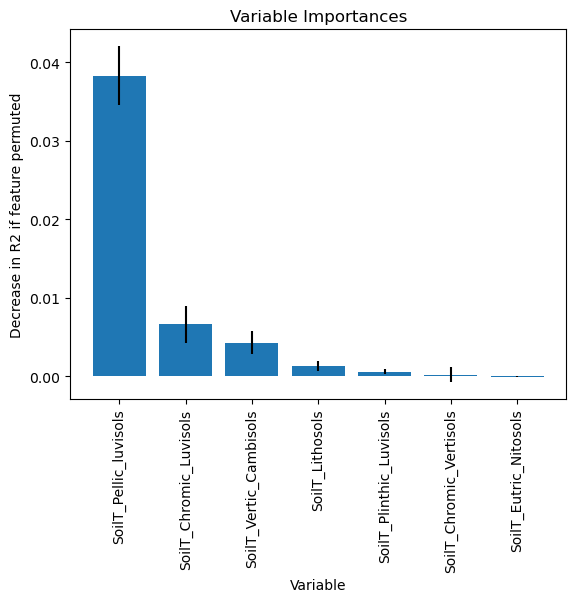

Time: 12.19  min
['Built_Area_Prop', 'Area_Built_Area', 'POP_mean', 'POP_median', 'RWI_mean', 'RWI_median', 'RWI_min', 'RWI_max', 'RWI_percentile_90']
{'n_estimators': 750, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 3, 'max_depth': 10, 'bootstrap': True}
{'bootstrap': True, 'max_depth': 10, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 550}
{'bootstrap': True, 'max_depth': 11, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 450}
MAE: [92.8322187749669, 61.07096225889645]
RMSE: [112.64023829656092, 77.34537888592736]
R2: [-0.5395286348808648, 0.3168990554611092]
Accuracy: [52.66068564651676, 66.7783993049922]


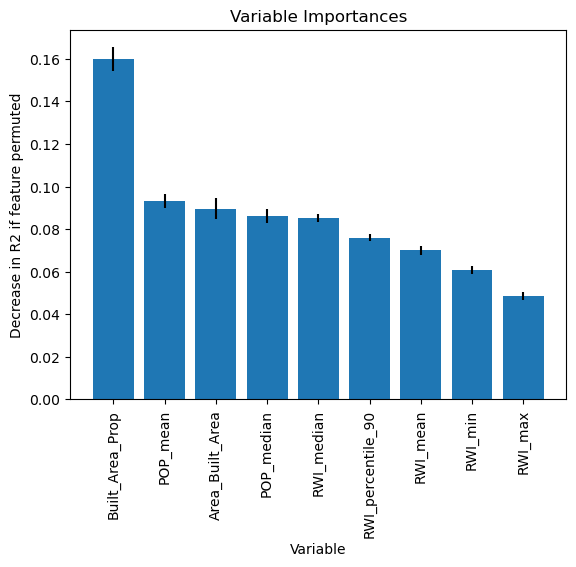

Time: 33.36  min
['POP_mean', 'POP_median']
{'n_estimators': 2000, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 1, 'max_depth': 10, 'bootstrap': True}
{'bootstrap': True, 'max_depth': 12, 'max_features': 1, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 1800}
{'bootstrap': True, 'max_depth': 13, 'max_features': 1, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 1700}
MAE: [93.02938333936467, 63.93292554284996]
RMSE: [113.90741496289628, 80.71548526797015]
R2: [-0.5733866703685211, 0.2560737770404714]
Accuracy: [52.681556929385025, 65.4571221995473]


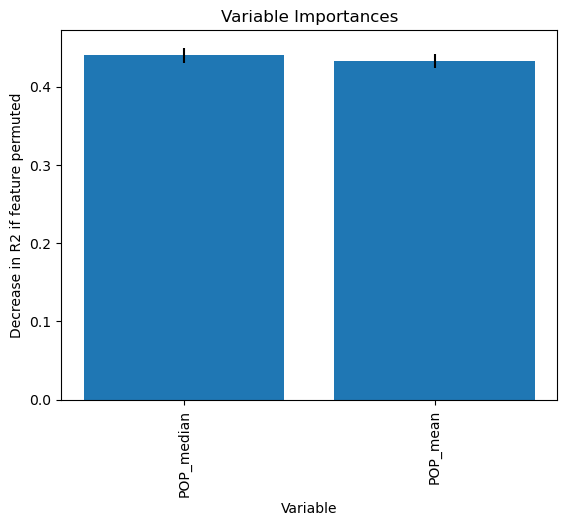

Time: 58.42  min
['RWI_mean', 'RWI_median', 'RWI_min', 'RWI_max', 'RWI_percentile_90']
{'n_estimators': 1250, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 2, 'max_depth': 10, 'bootstrap': True}
{'bootstrap': True, 'max_depth': 12, 'max_features': 2, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 1250}
{'bootstrap': True, 'max_depth': 11, 'max_features': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1250}
MAE: [93.68835702456373, 60.97999293027301]
RMSE: [113.60286366458345, 76.6722275022325]
R2: [-0.5690073391127575, 0.3287376257185384]
Accuracy: [52.371908727055626, 66.83260205801005]


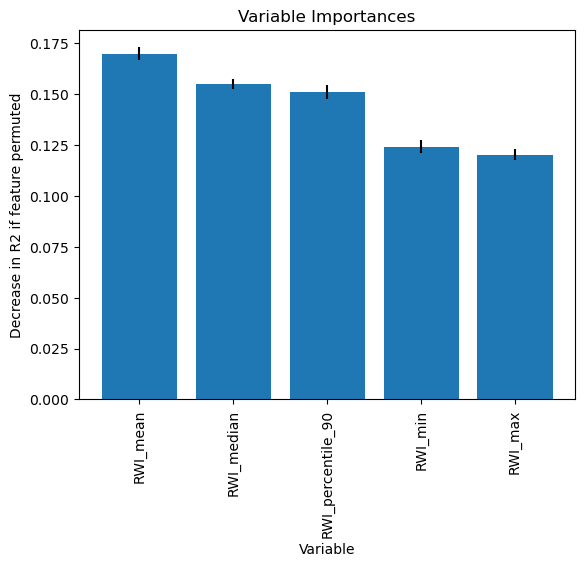

Time: 82.99  min
['Built_Area_Prop', 'Area_Built_Area']
{'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 1, 'max_depth': 10, 'bootstrap': True}
{'bootstrap': True, 'max_depth': 12, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 300}
{'bootstrap': True, 'max_depth': 11, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 200}
MAE: [94.2832301987894, 70.36407570681384]
RMSE: [114.18678829325515, 90.29762540399396]
R2: [-0.5814148694973641, 0.06895900791181686]
Accuracy: [51.948294814748266, 62.26874433985617]


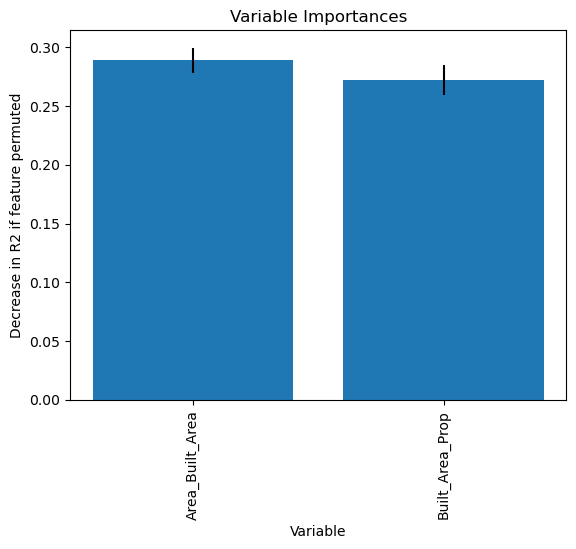

Time: 96.12  min
['SSM_mean', 'SSM_median', 'SSM_min', 'SSM_max', 'SSM_percentile_90', 'ST_mean', 'ST_median', 'ST_min', 'ST_max', 'ST_percentile_90']
{'n_estimators': 750, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 4, 'max_depth': 8, 'bootstrap': True}
{'bootstrap': True, 'max_depth': 8, 'max_features': 4, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 950}
{'bootstrap': True, 'max_depth': 7, 'max_features': 4, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 850}
MAE: [104.21692925912039, 58.61065629910483]
RMSE: [130.23934662166323, 77.90458766476256]
R2: [-1.177045431387037, 0.3069856780773882]
Accuracy: [54.921670558657354, 72.34786145650986]


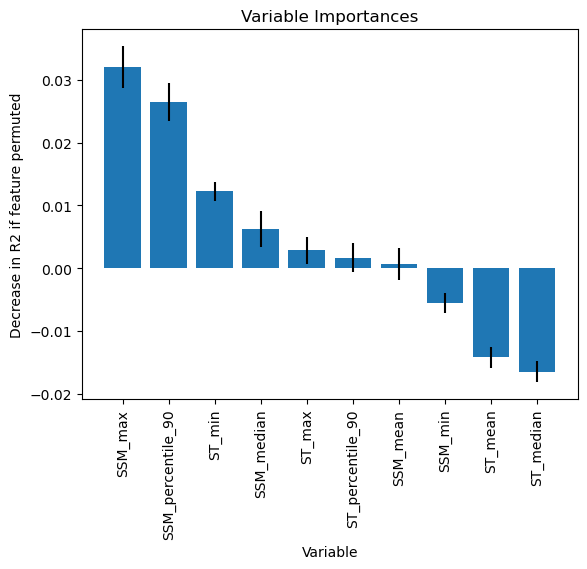

Time: 124.17  min
['PRE_mean', 'PRE_median', 'PRE_min', 'PRE_max', 'PRE_percentile_90', 'PRE_sum']
{'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 2, 'max_depth': 10, 'bootstrap': True}
{'bootstrap': True, 'max_depth': 12, 'max_features': 2, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 700}
{'bootstrap': True, 'max_depth': 13, 'max_features': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 800}
MAE: [91.61277662764195, 66.05861649775217]
RMSE: [115.61740812509179, 84.50790352828622]
R2: [-0.6527303847786502, 0.18452472274125642]
Accuracy: [53.313512933517785, 68.27599157848282]


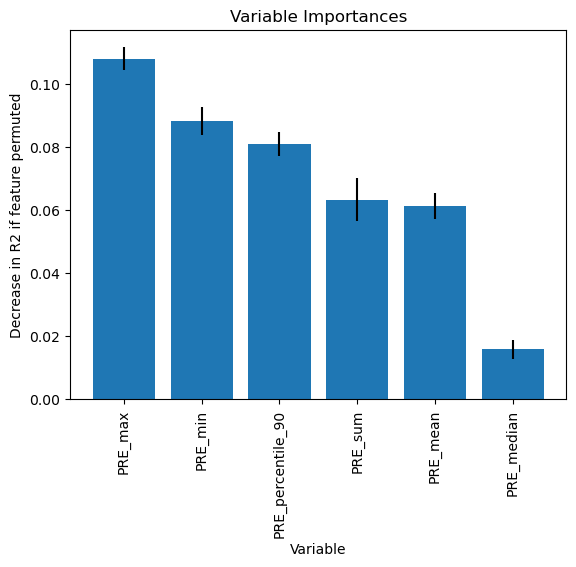

Time: 144.03  min
['SSM_mean', 'SSM_median', 'SSM_min', 'SSM_max', 'SSM_percentile_90']
{'n_estimators': 750, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 2, 'max_depth': 6, 'bootstrap': True}
{'bootstrap': True, 'max_depth': 8, 'max_features': 2, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 750}
{'bootstrap': True, 'max_depth': 8, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimators': 650}
MAE: [85.1411962838597, 61.914773376897145]
RMSE: [111.4142082485294, 81.15560680629179]
R2: [-0.4896394651174205, 0.24793876758009004]
Accuracy: [59.549475398935506, 69.82787580149093]


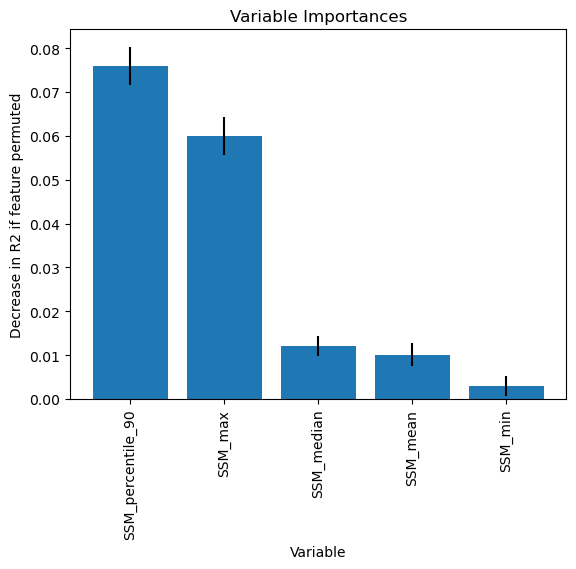

Time: 163.33  min
['ST_mean', 'ST_median', 'ST_min', 'ST_max', 'ST_percentile_90']
{'n_estimators': 500, 'min_samples_split': 15, 'min_samples_leaf': 4, 'max_features': 2, 'max_depth': 10, 'bootstrap': True}
{'bootstrap': True, 'max_depth': 12, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 17, 'n_estimators': 300}
{'bootstrap': True, 'max_depth': 13, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 16, 'n_estimators': 200}
MAE: [103.53392574126576, 66.89436583568457]
RMSE: [128.4303635322057, 88.6173584194723]
R2: [-1.2332984067456927, 0.10328642690086942]
Accuracy: [54.036047713447545, 66.01084732470795]


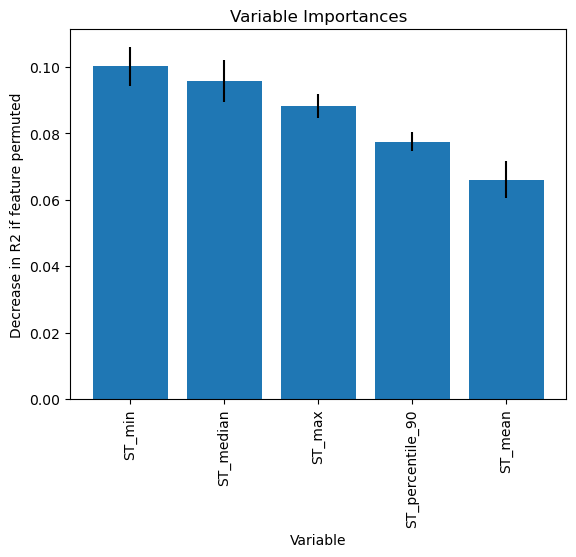

Time: 180.03  min
['BA_sum']
{'n_estimators': 750, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': 1, 'max_depth': 3, 'bootstrap': True}
{'bootstrap': True, 'max_depth': 1, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 13, 'n_estimators': 550}
{'bootstrap': True, 'max_depth': 1, 'max_features': 1, 'min_samples_leaf': 2, 'min_samples_split': 12, 'n_estimators': 450}
MAE: [95.68716705944146, 72.79619085531728]
RMSE: [119.67403283033627, 94.04179018931875]
R2: [-0.7573653749544811, -0.009852439570275928]
Accuracy: [50.78433020076813, 63.92774308435824]


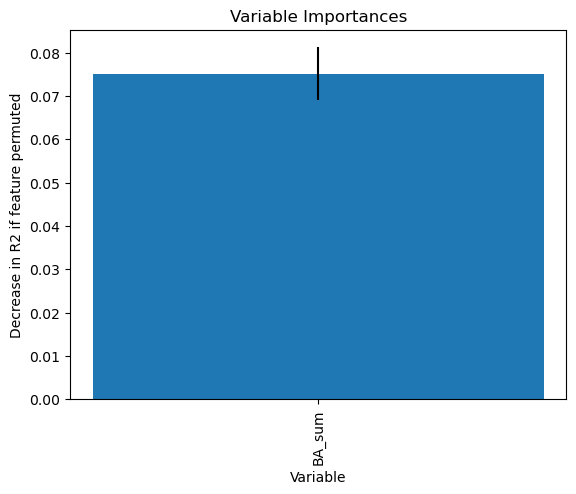

Time: 191.05  min
['Area_Crops', 'Area_Trees', 'Area_Built_Area', 'Crops_Prop', 'Trees_Prop', 'Built_Area_Prop', 'Area']
{'n_estimators': 2000, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 3, 'max_depth': 10, 'bootstrap': True}
{'bootstrap': True, 'max_depth': 10, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 2000}
{'bootstrap': True, 'max_depth': 9, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 2000}
MAE: [93.6883857459245, 63.985227669418386]
RMSE: [113.97468186355775, 80.88597853925295]
R2: [-0.5752710053619273, 0.25292770489626215]
Accuracy: [52.40911803418051, 65.45060280728558]


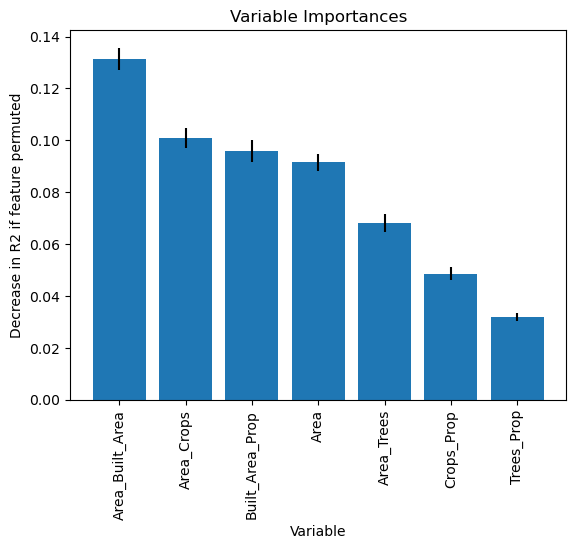

Time: 223.55  min
['Harvested_CropA_Paddy', 'Harvested_CropA_Maize', 'Harvested_CropA_Soybean', 'Harvested_CropA_Cotton', 'Harvested_CropA_Chillies', 'Harvested_CropA_Turmeric']
{'n_estimators': 1250, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 2, 'max_depth': 3, 'bootstrap': True}
{'bootstrap': True, 'max_depth': 1, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1050}
{'bootstrap': True, 'max_depth': 1, 'max_features': 2, 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 950}
MAE: [99.08077015967842, 71.0364172814803]
RMSE: [121.53222623421944, 91.02430925731913]
R2: [-0.8359544274716209, 0.0539133217714145]
Accuracy: [51.10863320702718, 62.29239367192907]


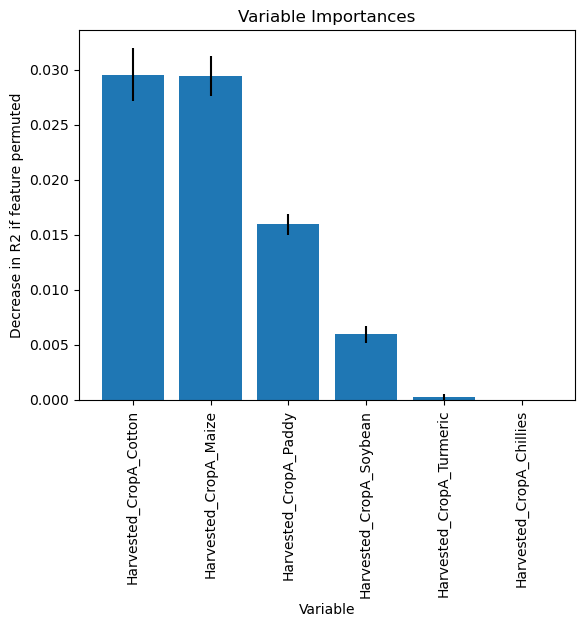

Time: 239.04  min
['PowP_score']
{'n_estimators': 1750, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 1, 'max_depth': 8, 'bootstrap': True}
{'bootstrap': True, 'max_depth': 8, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 1950}
{'bootstrap': True, 'max_depth': 8, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 2050}
MAE: [91.42915435519362, 63.7958329367384]
RMSE: [111.05405815087761, 79.41022880303973]
R2: [-0.4955148361861908, 0.27993941651977683]
Accuracy: [53.17587505858307, 65.70904049296634]


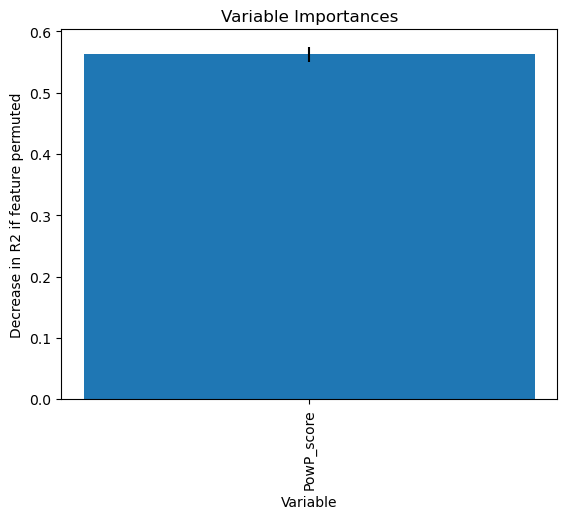

Time: 262.08  min
['SoilT_Chromic_Luvisols', 'SoilT_Chromic_Vertisols', 'SoilT_Eutric_Nitosols', 'SoilT_Lithosols', 'SoilT_Pellic_luvisols', 'SoilT_Plinthic_Luvisols', 'SoilT_Vertic_Cambisols']
{'n_estimators': 750, 'min_samples_split': 15, 'min_samples_leaf': 3, 'max_features': 3, 'max_depth': 3, 'bootstrap': True}
{'bootstrap': True, 'max_depth': 1, 'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 15, 'n_estimators': 550}
{'bootstrap': True, 'max_depth': 1, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 15, 'n_estimators': 450}
MAE: [12.049900121084658, 8.571244014963984]
RMSE: [13.48893813040007, 10.662784996810553]
R2: [-3.636348148269547, -0.003798189693888787]
Accuracy: [60.915709811053034, 71.19686366257349]


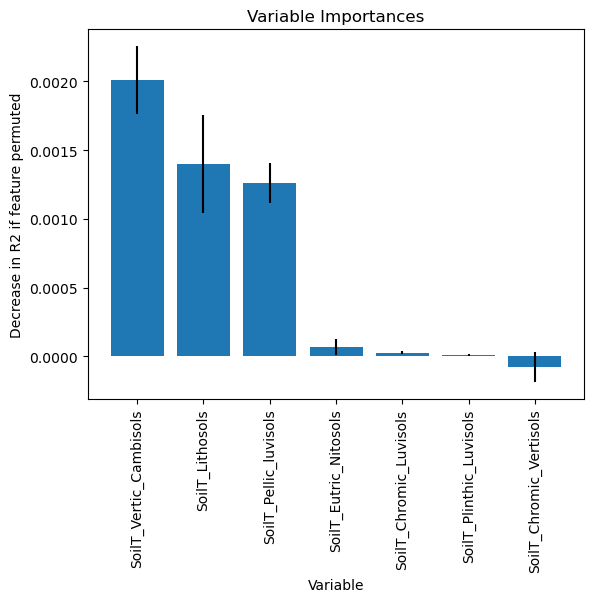

Time: 11.74  min
['Built_Area_Prop', 'Area_Built_Area', 'POP_mean', 'POP_median', 'RWI_mean', 'RWI_median', 'RWI_min', 'RWI_max', 'RWI_percentile_90']
{'n_estimators': 750, 'min_samples_split': 15, 'min_samples_leaf': 4, 'max_features': 3, 'max_depth': 4, 'bootstrap': True}
{'bootstrap': True, 'max_depth': 4, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 17, 'n_estimators': 550}
{'bootstrap': True, 'max_depth': 4, 'max_features': 3, 'min_samples_leaf': 2, 'min_samples_split': 17, 'n_estimators': 650}
MAE: [12.000285220438677, 8.453683920712008]
RMSE: [13.42164598647431, 10.509335440800918]
R2: [-3.6257689391511168, 0.024885505289095056]
Accuracy: [61.10391421791536, 71.51318687712225]


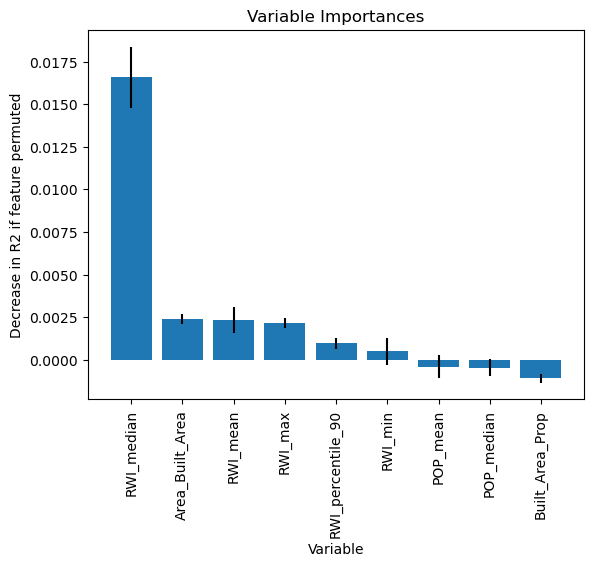

Time: 29.71  min
['POP_mean', 'POP_median']
{'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 1, 'max_depth': 4, 'bootstrap': True}
{'bootstrap': True, 'max_depth': 6, 'max_features': 1, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 300}
{'bootstrap': True, 'max_depth': 5, 'max_features': 1, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 400}
MAE: [12.011850351995207, 8.518066659829172]
RMSE: [13.444371131614918, 10.595368300859256]
R2: [-3.631048659950959, 0.008854944161683642]
Accuracy: [61.02548908943173, 71.33536739043114]


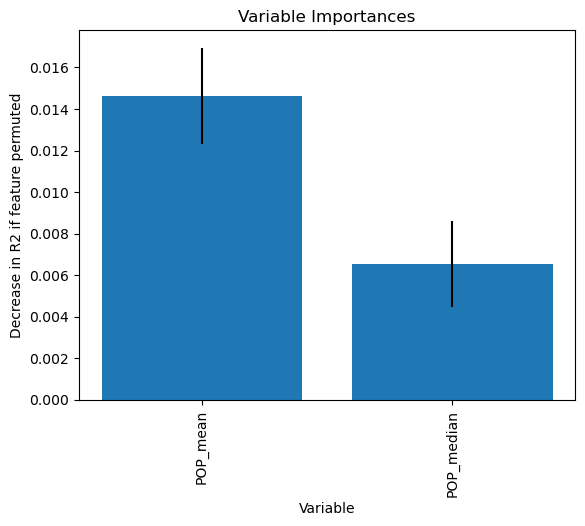

Time: 42.53  min
['RWI_mean', 'RWI_median', 'RWI_min', 'RWI_max', 'RWI_percentile_90']
{'n_estimators': 750, 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_features': 2, 'max_depth': 3, 'bootstrap': True}
{'bootstrap': True, 'max_depth': 3, 'max_features': 2, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 550}
{'bootstrap': True, 'max_depth': 2, 'max_features': 2, 'min_samples_leaf': 1, 'min_samples_split': 19, 'n_estimators': 550}
MAE: [11.996615750649983, 8.488863790935262]
RMSE: [13.431981218161933, 10.565828036589314]
R2: [-3.6314537211099314, 0.014373935297820384]
Accuracy: [61.04491184681069, 71.4101336991419]


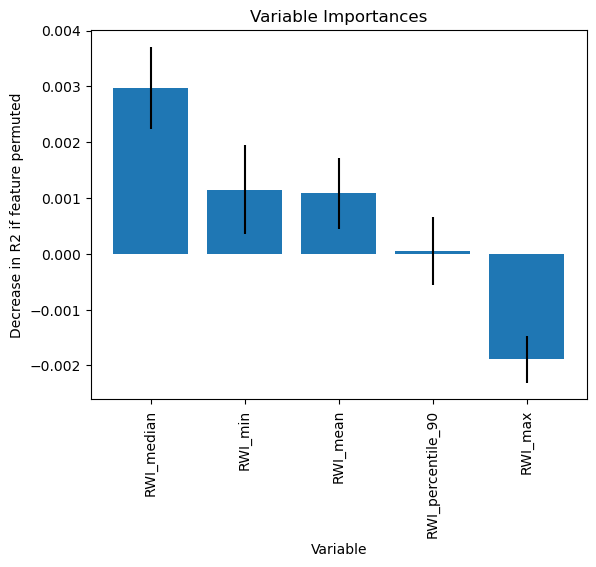

Time: 58.3  min
['Built_Area_Prop', 'Area_Built_Area']
{'n_estimators': 750, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 1, 'max_depth': 5, 'bootstrap': True}
{'bootstrap': True, 'max_depth': 5, 'max_features': 1, 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 550}
{'bootstrap': True, 'max_depth': 5, 'max_features': 1, 'min_samples_leaf': 3, 'min_samples_split': 9, 'n_estimators': 650}
MAE: [11.967842505359505, 8.516543509818975]
RMSE: [13.375617151844844, 10.585929965604006]
R2: [-3.608004257487622, 0.01061997817590521]
Accuracy: [61.17793011737348, 71.27053143717347]


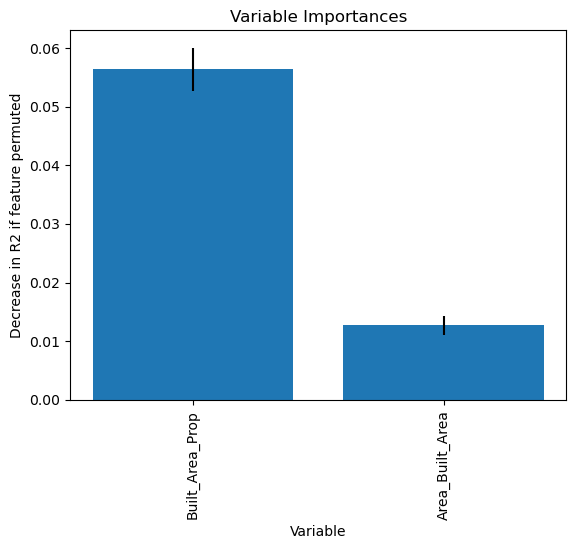

Time: 71.78  min
['SSM_mean', 'SSM_median', 'SSM_min', 'SSM_max', 'SSM_percentile_90', 'ST_mean', 'ST_median', 'ST_min', 'ST_max', 'ST_percentile_90']
{'n_estimators': 1250, 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_features': 4, 'max_depth': 5, 'bootstrap': True}
{'bootstrap': True, 'max_depth': 5, 'max_features': 4, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 1050}
{'bootstrap': True, 'max_depth': 5, 'max_features': 4, 'min_samples_leaf': 1, 'min_samples_split': 21, 'n_estimators': 1050}
MAE: [12.190045254152057, 5.912599151404176]
RMSE: [14.317961261810266, 7.7203077097084565]
R2: [-3.9361272210968075, 0.47377154944876976]
Accuracy: [61.944954499261584, 81.64839373356482]


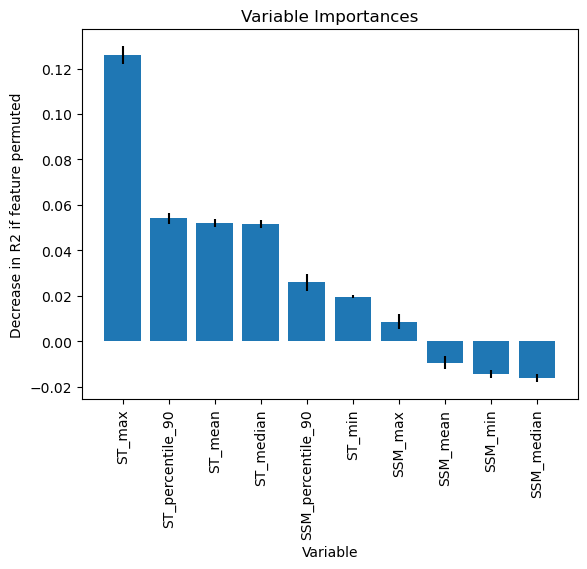

Time: 101.15  min
['PRE_mean', 'PRE_median', 'PRE_min', 'PRE_max', 'PRE_percentile_90', 'PRE_sum']
{'n_estimators': 1500, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 2, 'max_depth': 8, 'bootstrap': True}
{'bootstrap': True, 'max_depth': 8, 'max_features': 2, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 1500}
{'bootstrap': True, 'max_depth': 7, 'max_features': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1500}
MAE: [7.400654063936706, 6.558405984811389]
RMSE: [9.088231228020952, 8.598674473495091]
R2: [-0.6323109250081211, 0.34721807696101914]
Accuracy: [77.94116610148139, 79.8688255454907]


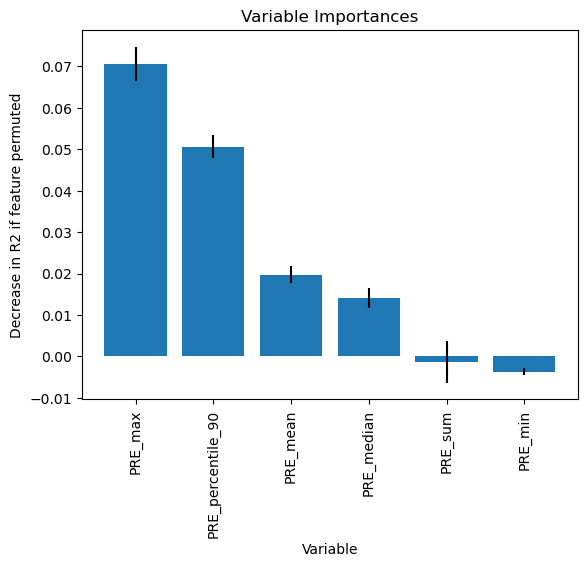

Time: 127.53  min
['SSM_mean', 'SSM_median', 'SSM_min', 'SSM_max', 'SSM_percentile_90']
{'n_estimators': 500, 'min_samples_split': 15, 'min_samples_leaf': 3, 'max_features': 2, 'max_depth': 3, 'bootstrap': True}
{'bootstrap': True, 'max_depth': 3, 'max_features': 2, 'min_samples_leaf': 2, 'min_samples_split': 15, 'n_estimators': 300}
{'bootstrap': True, 'max_depth': 2, 'max_features': 2, 'min_samples_leaf': 2, 'min_samples_split': 14, 'n_estimators': 300}
MAE: [14.829981129063713, 8.206298379868215]
RMSE: [17.027969724602674, 10.251453347289914]
R2: [-6.548676543683573, 0.07215382245937707]
Accuracy: [52.01054705766333, 72.7942716210293]


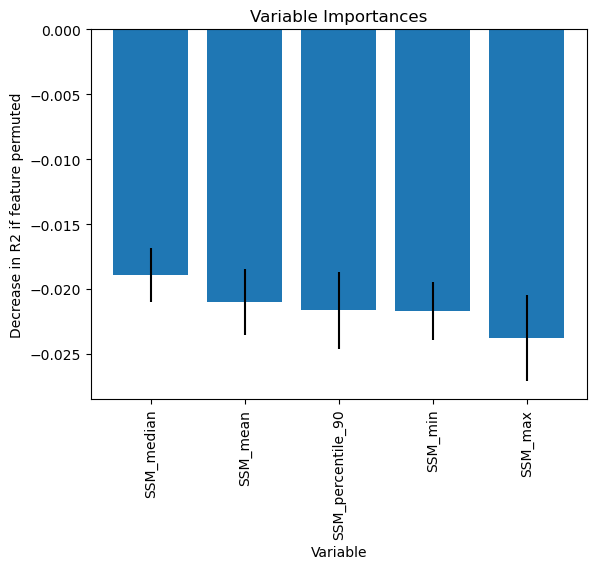

Time: 142.26  min
['ST_mean', 'ST_median', 'ST_min', 'ST_max', 'ST_percentile_90']
{'n_estimators': 1000, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': 2, 'max_depth': 3, 'bootstrap': True}
{'bootstrap': True, 'max_depth': 1, 'max_features': 2, 'min_samples_leaf': 1, 'min_samples_split': 17, 'n_estimators': 1200}
{'bootstrap': True, 'max_depth': 1, 'max_features': 2, 'min_samples_leaf': 1, 'min_samples_split': 16, 'n_estimators': 1100}
MAE: [11.03845529747631, 8.27956703804012]
RMSE: [12.755841052145271, 10.369363779355004]
R2: [-3.0124997939531317, 0.050687225360610655]
Accuracy: [64.88845747656516, 72.31918843967398]


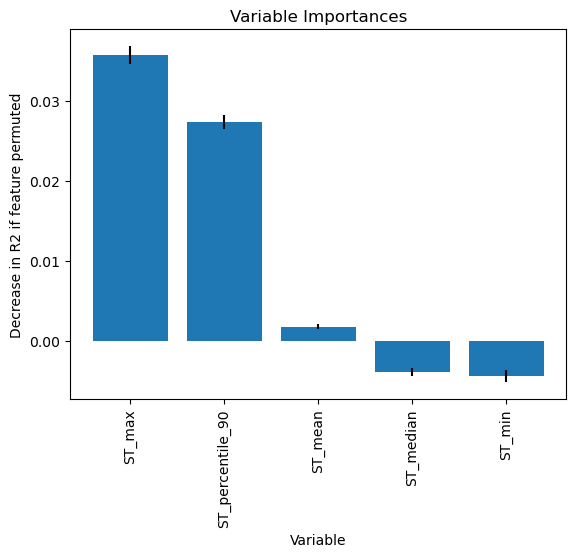

Time: 161.49  min
['BA_sum']
{'n_estimators': 1500, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 1, 'max_depth': 3, 'bootstrap': True}
{'bootstrap': True, 'max_depth': 3, 'max_features': 1, 'min_samples_leaf': 4, 'min_samples_split': 12, 'n_estimators': 1300}
{'bootstrap': True, 'max_depth': 3, 'max_features': 1, 'min_samples_leaf': 3, 'min_samples_split': 12, 'n_estimators': 1200}
MAE: [12.618650216961546, 8.559377031754709]
RMSE: [14.103193816081628, 10.832070893479806]
R2: [-3.988402142141654, -0.03592446817666506]
Accuracy: [59.67446466064062, 72.69896983564647]


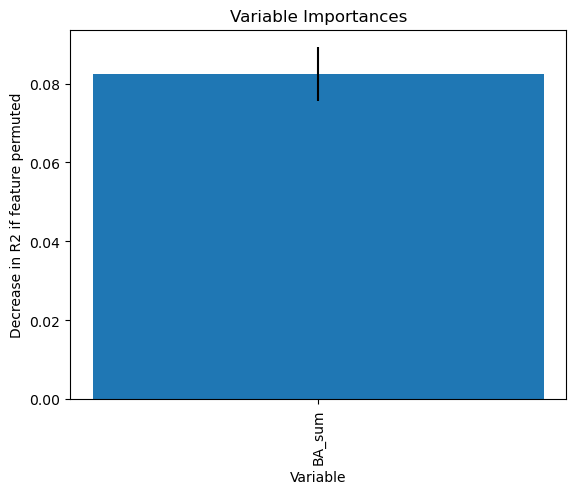

Time: 176.56  min
['Area_Crops', 'Area_Trees', 'Area_Built_Area', 'Crops_Prop', 'Trees_Prop', 'Built_Area_Prop', 'Area']
{'n_estimators': 500, 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_features': 3, 'max_depth': 7, 'bootstrap': True}
{'bootstrap': True, 'max_depth': 7, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 22, 'n_estimators': 300}
{'bootstrap': True, 'max_depth': 7, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 23, 'n_estimators': 300}
MAE: [11.977301400343666, 8.463889227203584]
RMSE: [13.36890552510166, 10.515441482870251]
R2: [-3.6167950877648796, 0.023752071142407516]
Accuracy: [61.18332322323407, 71.39644336958628]


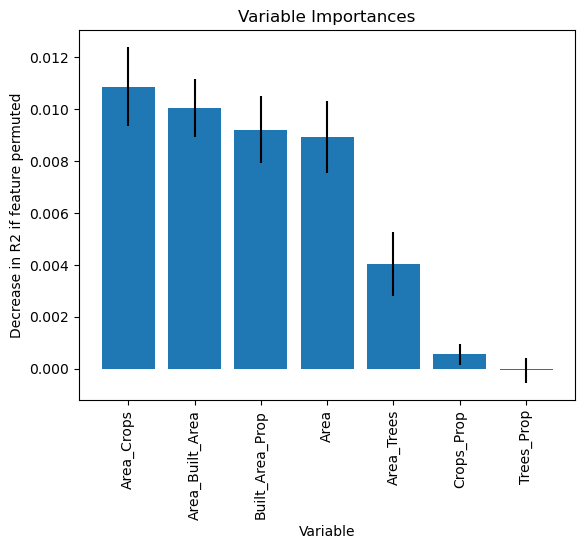

Time: 192.16  min
['Harvested_CropA_Paddy', 'Harvested_CropA_Maize', 'Harvested_CropA_Soybean', 'Harvested_CropA_Cotton', 'Harvested_CropA_Chillies', 'Harvested_CropA_Turmeric']
{'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 2, 'max_depth': 3, 'bootstrap': True}
{'bootstrap': True, 'max_depth': 1, 'max_features': 2, 'min_samples_leaf': 5, 'min_samples_split': 12, 'n_estimators': 300}
{'bootstrap': True, 'max_depth': 1, 'max_features': 2, 'min_samples_leaf': 5, 'min_samples_split': 12, 'n_estimators': 200}
MAE: [12.287966422266358, 8.617877502033506]
RMSE: [13.839096273517448, 10.739013846610641]
R2: [-4.054249921580819, -0.01820191227884216]
Accuracy: [60.26317997461926, 70.9358856655087]


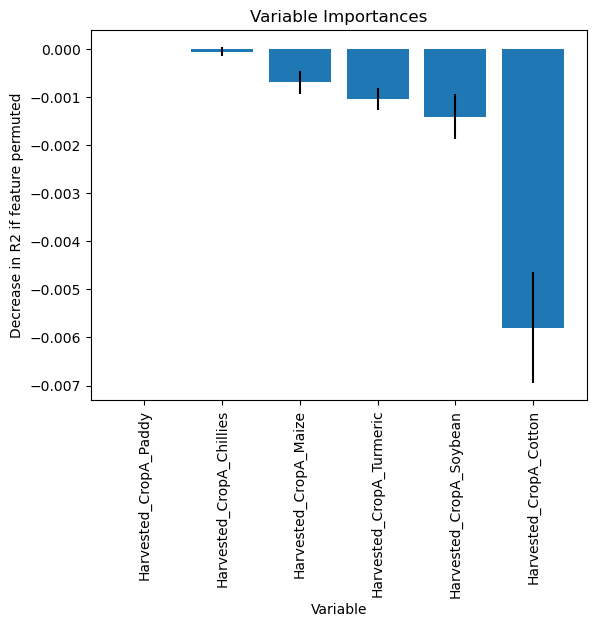

Time: 203.73  min
['PowP_score']
{'n_estimators': 500, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': 1, 'max_depth': 5, 'bootstrap': True}
{'bootstrap': True, 'max_depth': 5, 'max_features': 1, 'min_samples_leaf': 2, 'min_samples_split': 13, 'n_estimators': 300}
{'bootstrap': True, 'max_depth': 6, 'max_features': 1, 'min_samples_leaf': 2, 'min_samples_split': 12, 'n_estimators': 400}
MAE: [12.066765387627632, 8.417184550209827]
RMSE: [13.46988657035774, 10.491155892477025]
R2: [-3.646656859628295, 0.02825618625208448]
Accuracy: [60.93429612849872, 71.62271800898989]


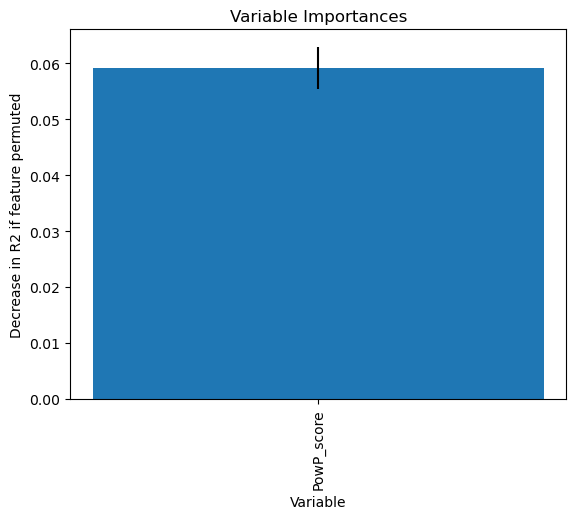

Time: 216.52  min


In [330]:
data = data_all

k_folds = 4

os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\sandbox\\notebooks\\crop_fires\\Model\\Results')

df_NO2 = RandomForestRegressionModelSubsets(k_fold = 4, feature_com_list = feature_list_comb, data = data, train_data = train, test_data = test, predictor = 'NO2', n_iters=250)

df_NO2.to_csv('results_NO2_subsets_all_months.csv')


df_PM25 = RandomForestRegressionModelSubsets(k_fold = 4, feature_com_list = feature_list_comb, data = data, train_data = train, test_data = test, predictor = 'PM2.5', n_iters=250)

df_PM25.to_csv('results_PM25_subsets_all_months.csv')


# NO2

['PowP_score', 'RWI_mean', 'SSM_percentile_90', 'SoilT_Pellic_luvisols', 'Harvested_CropA_Paddy', 'Harvested_CropA_Maize', 'Harvested_CropA_Cotton', 'POP_median', 'Area_Built_Area', 'PRE_max', 'ST_max']
{'n_estimators': 500, 'min_samples_split': 15, 'min_samples_leaf': 3, 'max_features': 4, 'max_depth': 6, 'bootstrap': True}
{'bootstrap': True, 'max_depth': 6, 'max_features': 4, 'min_samples_leaf': 3, 'min_samples_split': 15, 'n_estimators': 300}
{'bootstrap': True, 'max_depth': 6, 'max_features': 4, 'min_samples_leaf': 4, 'min_samples_split': 15, 'n_estimators': 200}
MAE: [85.59719989871111, 45.29656405379252]
RMSE: [106.09124797411809, 57.11425734028003]
R2: [-0.38731591088409684, 0.6275180678877643]
Accuracy: [60.449911955085526, 77.61786234547655]


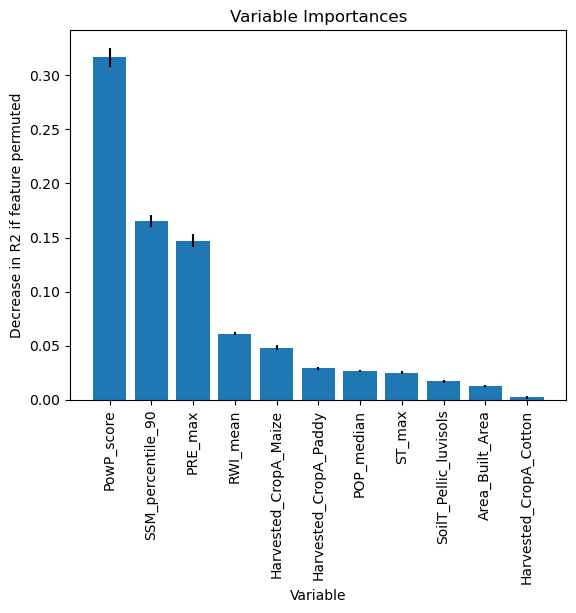

Time: 21.61  min


In [343]:
data = data_all
predictor = 'NO2'
feature_list_comb = [['PowP_score',
 'RWI_mean',
 'SSM_percentile_90',
 'SoilT_Pellic_luvisols',
 'Harvested_CropA_Paddy',
 'Harvested_CropA_Maize',
 'Harvested_CropA_Cotton',
 'POP_median',
 'Area_Built_Area',
 'PRE_max',
 'ST_max']]
 
data = data_all

k_folds = 4

os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\sandbox\\notebooks\\crop_fires\\Model\\Results')

df_findings = RandomForestRegressionModelSubsets(k_fold = 4, feature_com_list = feature_list_comb, data = data, train_data = train, test_data = test, predictor = 'NO2', n_iters=250)




In [332]:
print(df_findings['Parameters'][0])

{'bootstrap': True, 'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 13, 'n_estimators': 400}


In [342]:
df_findings

,MAE,RMSE,R2,Accuracy,Features,Parameters,Feature Importances
0,"[85.69803933939852, 44.72257415385825]","[105.92867881002088, 56.429581083583614]","[-0.3810864781071862, 0.6363950425998393]","[60.359490550318064, 77.8446491810907]","[PowP_score, RWI_mean, SSM_max, SoilT_Pellic_l...","{'bootstrap': True, 'max_depth': 6, 'max_featu...","[(PowP_score, 0.326264904958169, 0.00813652818..."


Now we use the parameters chosen and run for different max depths

In [349]:
subsets_filtered = [['PowP_score',
 'RWI_mean',
 'SSM_max',
 'SoilT_Pellic_luvisols',
 'Harvested_CropA_Paddy',
 'Harvested_CropA_Maize',
 'POP_median',
 'Area_Built_Area',
 'PRE_max',
 'ST_max']]

In [350]:
maxdepths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
predictor = 'NO2'
k_fold = 4
btscv = BlockingTimeSeriesSplit(n_splits = k_fold)
parameters_tuned_final = df_findings['Parameters'][0]

#parameters_tuned_final['min_samples_split'] = 5
parameter_scores = []
x = 0

for features_com in subsets_filtered:
    parameters = parameters_tuned_final.copy()
    parameters['max_features'] = math.ceil(len(features_com)/3)
    for depth in maxdepths:
        
        parameters['max_depth'] = depth

        rf_model, MAE, RMSE, R2, Accuracy = RandomForestRegressionModel(parameters, data, train_data = train, test_data = test, features_com = features_com, predictor = predictor, btscv = btscv)

        predictions_train = rf_model.predict(train[features_com])

        MAE_train = mean_absolute_error(train[predictor], predictions_train)
        RMSE_train =  math.sqrt(np.square(np.subtract(train[predictor], predictions_train)).mean())
        R2_train = r2_score(train[predictor], predictions_train)
        Accuracy_train = 100 - np.mean(100 * ((abs(predictions_train-train[predictor]))/train[predictor]))

        parameter_scores.append((x, MAE[1], RMSE[1], R2[1], Accuracy[1], MAE_train, RMSE_train, R2_train, Accuracy_train, features_com, depth))
    x = x + 1

results = pd.DataFrame(parameter_scores, columns = ['Feature_set', 'MAE_test', 'RMSE_test', 'R2_test', 'Accuracy_test', 'MAE_train', 'RMSE_train', 'R2_train', 'Accuracy_train', 'Features', 'max_depth'])

In [ ]:
os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\sandbox\\notebooks\\crop_fires\\Model\\Results')

results.to_csv('results_NO2_trials_final.csv')

In [ ]:
os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\sandbox\\notebooks\\crop_fires\\Model\\Results')
results_NO2 = pd.read_csv('results_NO2_trials.csv', index_col = 0)

In [ ]:
results_NO2 = results_NO2.sort_values(by='R2_test', ascending=False)

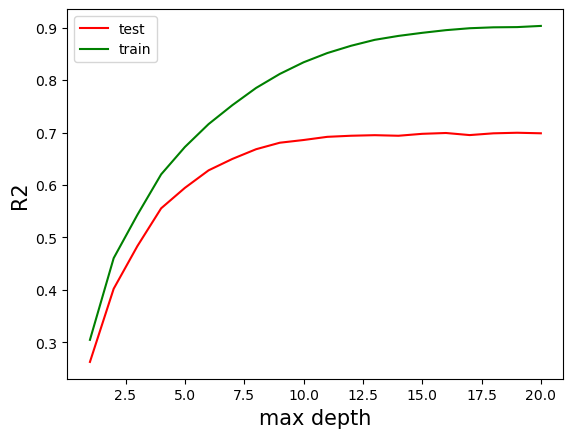

()

In [367]:
plot_max_depth(results, 'NO2')

# PM2.5

['PowP_score', 'RWI_median', 'SSM_median', 'PRE_max', 'ST_max', 'Harvested_CropA_Paddy', 'Harvested_CropA_Maize']
{'n_estimators': 750, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 3, 'max_depth': 8, 'bootstrap': True}
{'bootstrap': True, 'max_depth': 8, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 550}
{'bootstrap': True, 'max_depth': 9, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 550}
MAE: [10.658349689037951, 5.1146562282203645]
RMSE: [12.57884572427251, 6.775522205645438]
R2: [-3.3000805250213174, 0.5946868917109116]
Accuracy: [66.32264962796188, 85.01951209720275]


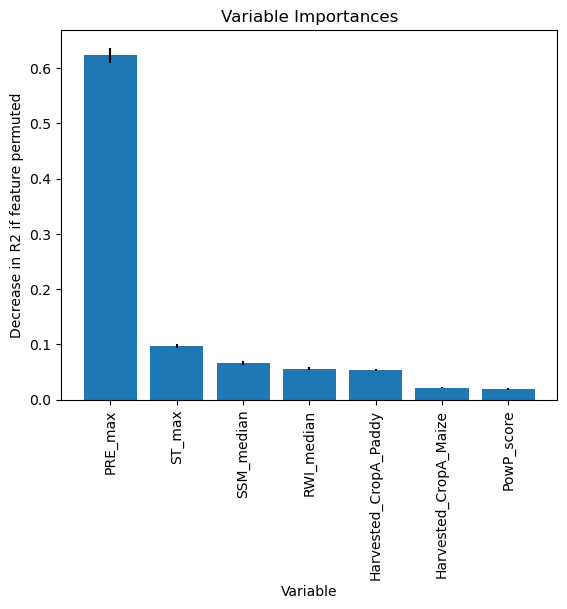

Time: 29.33  min


In [360]:
data = data_all
predictor = 'PM2.5'
feature_list_comb = [['PowP_score',
 'RWI_median',
 'SSM_median',
 'PRE_max',
 'ST_max',
 'Harvested_CropA_Paddy',
 'Harvested_CropA_Maize']]
data = data_all

k_folds = 4

os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\sandbox\\notebooks\\crop_fires\\Model\\Results')

df_findings_2 = RandomForestRegressionModelSubsets(k_fold = 4, feature_com_list = feature_list_comb, data = data, train_data = train, test_data = test, predictor = predictor , n_iters=250)



In [361]:
print(df_findings_2['Parameters'][0])

{'bootstrap': True, 'max_depth': 9, 'max_features': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 550}


In [363]:
subsets_filtered = [['PowP_score',
 'RWI_median',
 'SSM_median',
 'PRE_max',
 'ST_max',
 'Harvested_CropA_Paddy',
 'Harvested_CropA_Maize']]

In [364]:
maxdepths =  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
predictor = 'PM2.5'
k_fold = 4
btscv = BlockingTimeSeriesSplit(n_splits = k_fold)
parameters_tuned_final = df_findings_2['Parameters'][0]

parameter_scores = []
x = 0

for features_com in subsets_filtered:
    parameters = parameters_tuned_final.copy()
    parameters['max_features'] = math.ceil(len(features_com)/3)

    for depth in maxdepths:
        
        parameters['max_depth'] = depth

        rf_model, MAE, RMSE, R2, Accuracy = RandomForestRegressionModel(parameters, data, train_data = train, test_data = test, features_com = features_com, predictor = predictor, btscv = btscv)

        predictions_train = rf_model.predict(train[features_com])

        MAE_train = mean_absolute_error(train[predictor], predictions_train)
        RMSE_train =  math.sqrt(np.square(np.subtract(train[predictor], predictions_train)).mean())
        R2_train = r2_score(train[predictor], predictions_train)
        Accuracy_train = 100 - np.mean(100 * ((abs(predictions_train-train[predictor]))/train[predictor]))

        parameter_scores.append((x, MAE[1], RMSE[1], R2[1], Accuracy[1], MAE_train, RMSE_train, R2_train, Accuracy_train, features_com, depth))
    x = x + 1

results_PM25 = pd.DataFrame(parameter_scores, columns = ['Feature_set', 'MAE_test', 'RMSE_test', 'R2_test', 'Accuracy_test', 'MAE_train', 'RMSE_train', 'R2_train', 'Accuracy_train', 'Features', 'max_depth'])

In [ ]:
os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\sandbox\\notebooks\\crop_fires\\Model\\Results')

results_PM25.to_csv('results_PM25_final.csv')

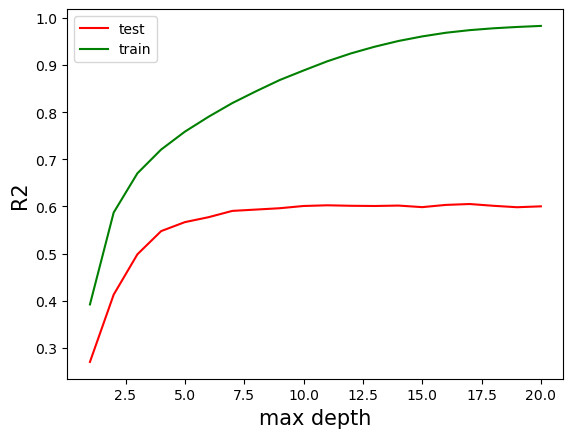

()

In [368]:
plot_max_depth(results_PM25, predictor)